# 基于 DQAS 算法的 MNIST 手写数字二分类问题

完成人: 杨建飞 2024.11.26

## 开源实习任务介绍

量子线路的不同设计方式会严重影响到量子变分算法、量子神经网络等应用的效果，受到经典神经网络设计的启发，量子线路的自适应选取有望提高量子算法的效率和精度，本任务旨在构建一套量子线路结构搜索框架，可以自适应地完成量子线路设计并提高结果精度。需要设计一套自适应的程序框架，在给定量子门集合中自动选取最优的组合来实现目标量子算法。  
要求基于 MindQuantum==0.9 框架，实现 mnist 数据集识别准确度比文献“https://doi.org/10.1016/j.neunet.2023.09.040”更高

## DQAS 算法介绍

[DQAS 算法[1]](https://arxiv.org/abs/2010.08561)是一种基于可微量子结构搜索的算法,将 Ansatz 的搜索过程分为了两个目标：结构搜索和参数搜索，并且在算法中进行同时优化，是一种双优化算法。首先需要预定义的是两个部分：**算符池(Operator Pool)**和**共享参数池(Shared Parameter Pool)**。算符池中存储的是预定义量子门，共享参数池中存储的是量子门参数。

### 算符池(Operator Pool)

算符池中是预定义的量子线路片段，被称为“算符(Operator)”. 请注意算符可能是参数化的，也可能不是参数化的。在本项目中的预定义算符池成员如下：

1. Rx(θ1)Ry(θ2)Rz(θ3)门
2. CNOT 门

需注意作用在不同的量子比特上可以视为不同的算符，因此当量子比特数目增加时，设计算符池存在困难。在本项目的实践过程中，采用了一种更加具有拓展性的算符池设计方式,被称为[Micro Search](https://proceedings.mlr.press/v202/wu23v/wu23v.pdf)，其核心思想是，只设计一个子线路(Sub Circuit),通过重复这个子线路的结构能够拼成一个完整线路。(仅仅是结构重复，变分参数并不相同)，示意图如下:  
![图片alt](./asset/MicroSearch.png)

### 共享参数池(Shared Parameter Pool)

共享参数池中存储的是量子门参数，这些参数是共享的，也就是每次生成的 Ansatz 会直接从共享参数池中的对应位置直接获取一个参数作为变分参数(这当然不是最优参数),绑定好后再进行损失值的测定。最后将会根据 loss 测定带来的梯度，更新对应参数池对应位置的参数。  
尽管共享参数池的概念，不完全符合 VQA 算法找寻最优变分参数的惯例，但这样的设计方案大大降低了算法的运行时间和复杂度。到了后期共享参数池不断地被更新，且候选结构相对固定，便会接近有固定 ansatz 结构的 VQA 算法。


## 数据预处理部分

在本项目中对 MNIST 手写数字数据集中的"3"和"6"图片进行了 PCA 降维到 8 维, 同时将降维数据映射到[0,π]区间，并进行了归一化处理。  
在量子线路中的 Data Encoding 部分,采用了 PCA 数据+角度编码(8 量子比特)的方式完成。
此外，需要格外关注的一点是,MNIST 手写数据集中"3"和"6"的个数总数为 11446, 而 DQAS 只抽样使用了其中的 10%，后续微调过程则在完整的数据集上实现。


In [ ]:
!pip install -r requirements.txt

In [1]:
from torchvision import datasets
from data_preprocessing import pca_data_preprocessing

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
# 载入预处理、采样 10% 过后的的二分类认为训练和测试数据集
x_train, x_test, y_train, y_test = pca_data_preprocessing(mnist_dataset, 8)

In [2]:
from mindquantum.core.parameterresolver import PRGenerator
import numpy as np
from mindquantum.core.gates import RX, RY, RZ, X, I
from mindquantum.core.circuit import UN
import mindspore as ms
import pickle
from mindquantum.core.parameterresolver import PRGenerator
from mindspore import ops
import tensorcircuit as tc
import tensorflow as tf

pr_pool = PRGenerator('pool')

# 定义参数化算符池 加入I门填充空余比特 是为了方便后续操作
parameterized_circuit = [
    UN(RX(pr_pool.new()), maps_obj=[0])
    + UN(RY(pr_pool.new()), maps_obj=[0])
    + UN(RZ(pr_pool.new()), maps_obj=[0])
    + I.on(1),
    UN(RX(pr_pool.new()), maps_obj=[1])
    + UN(RY(pr_pool.new()), maps_obj=[1])
    + UN(RZ(pr_pool.new()), maps_obj=[1])
    + I.on(0),
]

# 定义非参数化算符池
unparameterized_circuit = [
    UN(X, maps_obj=[0], maps_ctrl=[1]),
    UN(X, maps_obj=[1], maps_ctrl=[0]),
]
ansatz_pr = PRGenerator('ansatz')
shape_parametized = len(parameterized_circuit)
shape_unparameterized = len(unparameterized_circuit)

# 设定具体的微观搜索中子线路的结构占位符个数
num_layer = 4
shape_nnp = (7, num_layer, shape_parametized, 3)  # 定义共享参数池的尺寸
shape_stp = (num_layer, shape_unparameterized + shape_parametized)  # 定义结构参数的初始尺寸
stddev = 0.03
np.random.seed(2)
nnp = np.random.normal(loc=0.0, scale=stddev, size=shape_nnp)  # 生成随机分布的共享参数池
stp = np.random.normal(loc=0.0, scale=stddev, size=shape_stp)  # 生成随机分布的结构参数
ops_onehot = ops.OneHot(axis=-1)  # 定义onehot编码算子

/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR
Please first ``pip install -U qiskit`` to enable related functionality in translation module


## 算符池的具体定义

查看算符池的各个成员


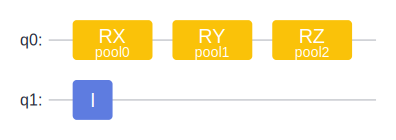

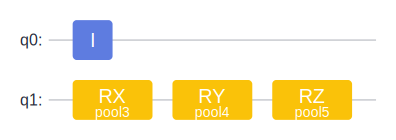

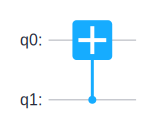

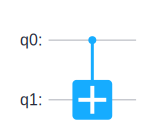

In [3]:
for each_op in parameterized_circuit:
    display(each_op.svg())
for each_op in unparameterized_circuit:
    display(each_op.svg())

## 开始进行DQAS算法的迭代

In [4]:
from dqas_tool import (
    sampling_from_structure,
    vag_nnp_micro_minipool,
    best_from_structure,
    zeroslike_grad_nnp_micro_minipool,
    nmf_gradient,
    dqas_accuracy_custom,
    mindspore_ansatz_micro_minipool,
    nnp_dealwith,
)

K = tc.set_backend("tensorflow")
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.06, 100, 0.5)
structure_opt = tc.backend.optimizer(tf.keras.optimizers.Adam(0.1))
network_opt = tc.backend.optimizer(tf.keras.optimizers.Adam(lr))
verbose = False
# 设置超参数
epochs = 15
batch_size = 100
avcost1 = 0
ops_onehot = ops.OneHot(axis=-1)
batch_loss_history = []  # 记录每个epoch的batch_size损失值
structure_distribution_history = []  # 记录每个epoch的结构参数
ansatz_params_history = []  # 记录每个epoch的网络参数
best_candidates_history = []  # 记录每个epoch的最佳候选
acc_history = []  # 记录每个epoch的准确率


for epoch in range(epochs):  # 更新结构参数的迭代
    avcost2 = avcost1
    costl = []
    tmp = np.stack([sampling_from_structure(stp, num_layer, shape_parametized) for _ in range(batch_size)])
    batch_structure = ops_onehot(ms.Tensor(tmp), shape_parametized + shape_unparameterized, ms.Tensor(1), ms.Tensor(0))
    # print(batch_structure.shape)
    # print(tmp,batch_structure)
    loss_value = []
    grad_nnps = []
    grad_stps = []

    for i in batch_structure:
        # print(ops.Argmax()(i))
        infd, grad_nnp = vag_nnp_micro_minipool(
            structure_params=i,
            ansatz_params=nnp,
            paramerterized_pool=parameterized_circuit,
            unparamerterized_pool=unparameterized_circuit,
            num_layer=num_layer,
            n_qbits=8,
        )(ms.Tensor(x_train), ms.Tensor(y_train))

        grad_nnp_zeroslike = zeroslike_grad_nnp_micro_minipool(
            batch_sturcture=i, grad_nnp=grad_nnp[0], shape_parametized=shape_parametized, ansatz_parameters=nnp
        )
        gs = nmf_gradient(structures=stp, oh=i, num_layer=num_layer, size_pool=stp.shape[1])
        # print(infd,grad_nnp)
        loss_value.append(infd)
        grad_nnps.append(ms.Tensor(grad_nnp_zeroslike, dtype=ms.float64))
        grad_stps.append(gs)

    infd = ops.stack(loss_value)
    gnnp = ops.addn(grad_nnps)
    gstp = [(infd[i] - avcost2) * grad_stps[i] for i in range(infd.shape[0])]
    gstp_averge = ops.addn(gstp) / infd.shape[0]
    avcost1 = sum(infd) / infd.shape[0]
    # print(f'loss={infd}\ngrad_nnp={gnnp}\ngrandient_stp={gstp_averge}')

    gnnp_tf = tf.convert_to_tensor(gnnp.asnumpy(), dtype=tf.float64)
    nnp_tf = tf.convert_to_tensor(nnp, dtype=tf.float64)
    gstp_averge_tf = tf.convert_to_tensor(gstp_averge.reshape(stp.shape).asnumpy(), dtype=tf.float64)
    stp_tf = tf.convert_to_tensor(stp, dtype=tf.float64)
    # 更新一步参数
    nnp_tf = network_opt.update(gnnp_tf, nnp_tf)
    stp_tf = structure_opt.update(gstp_averge_tf, stp_tf)

    nnp = nnp_tf.numpy()
    stp = stp_tf.numpy()

    batch_loss_history.append(avcost1)
    structure_distribution_history.append(stp)
    ansatz_params_history.append(nnp)
    # best_candidates_history.append(best_from_structure(cand_preset.asnumpy()))
    cand_preset = best_from_structure(stp)
    best_candidates_history.append(cand_preset.asnumpy())

    if epoch % 1 == 0 or epoch == epochs - 1:
        print("----------epoch %s-----------" % epoch)
        print(
            "batched平均损失: ",
            avcost1,
        )

        if verbose:
            print(
                "structure parameter: \n",
                stp,
                "\n network parameter: \n",
                nnp,
            )

        print("最好的候选结构:", cand_preset)
        stp_for_test = ops_onehot(
            ms.Tensor(cand_preset), shape_parametized + shape_unparameterized, ms.Tensor(1), ms.Tensor(0)
        )

        if cand_preset.min() < shape_parametized:
            ansatz_parameters = nnp_dealwith(structure_params=stp_for_test, network_params=nnp)
            test_ansatz = mindspore_ansatz_micro_minipool(
                structure_p=stp_for_test,
                parameterized_pool=parameterized_circuit,
                unparameterized_pool=unparameterized_circuit,
                num_layer=num_layer,
                n_qbits=8,
            )
            acc = dqas_accuracy_custom(
                ansatz=test_ansatz, network_params=ansatz_parameters, x=x_train, y=y_train, n_qbits=8
            )
            acc_history.append(acc)
            print(f'二分类准确率 Acc ={acc*100}% ')

        # 我想每一轮结束 保存batch_loss_history、structure_distribution_history、ansatz_params_history、best_candidates_history、acc_history
        # 保存数据
        np.savez(
            'training_history-minipool-k4.npz',
            batch_loss_history=batch_loss_history,
            structure_distribution_history=structure_distribution_history,
            ansatz_params_history=ansatz_params_history,
            best_candidates_history=best_candidates_history,
            acc_history=acc_history,
        )

----------epoch 0-----------
batched平均损失:  0.89857846
最好的候选结构: [2 2 3 3]
----------epoch 1-----------
batched平均损失:  0.8150909
最好的候选结构: [2 2 3 3]
----------epoch 2-----------
batched平均损失:  0.7842525
最好的候选结构: [2 2 3 3]
----------epoch 3-----------
batched平均损失:  0.77199715
最好的候选结构: [2 2 3 3]
----------epoch 4-----------
batched平均损失:  0.7360642
最好的候选结构: [2 2 3 3]
----------epoch 5-----------
batched平均损失:  0.70016533
最好的候选结构: [2 2 3 3]
----------epoch 6-----------
batched平均损失:  0.7059648
最好的候选结构: [2 2 3 3]
----------epoch 7-----------
batched平均损失:  0.69714254
最好的候选结构: [2 2 3 3]
----------epoch 8-----------
batched平均损失:  0.65290815
最好的候选结构: [2 2 3 3]
----------epoch 9-----------
batched平均损失:  0.6651093
最好的候选结构: [2 2 3 3]
----------epoch 10-----------
batched平均损失:  0.62112176
最好的候选结构: [2 2 3 3]
----------epoch 11-----------
batched平均损失:  0.64050263
最好的候选结构: [2 2 3 3]
----------epoch 12-----------
batched平均损失:  0.6634721
最好的候选结构: [2 2 3 0]
二分类准确率 Acc =64.797507788162% 
----------epoch 13------

目前已经可以得到了最终的 Ansatz,[1,1,3,0],其对应的量子线路如下：


In [6]:
# 加载
data = np.load('training_history-minipool-k4.npz',allow_pickle=True)
batch_loss_history = data['batch_loss_history']
structure_distribution_history = data['structure_distribution_history']
ansatz_params_history = data['ansatz_params_history']
best_candidates_history = data['best_candidates_history']
acc_history = data['acc_history']

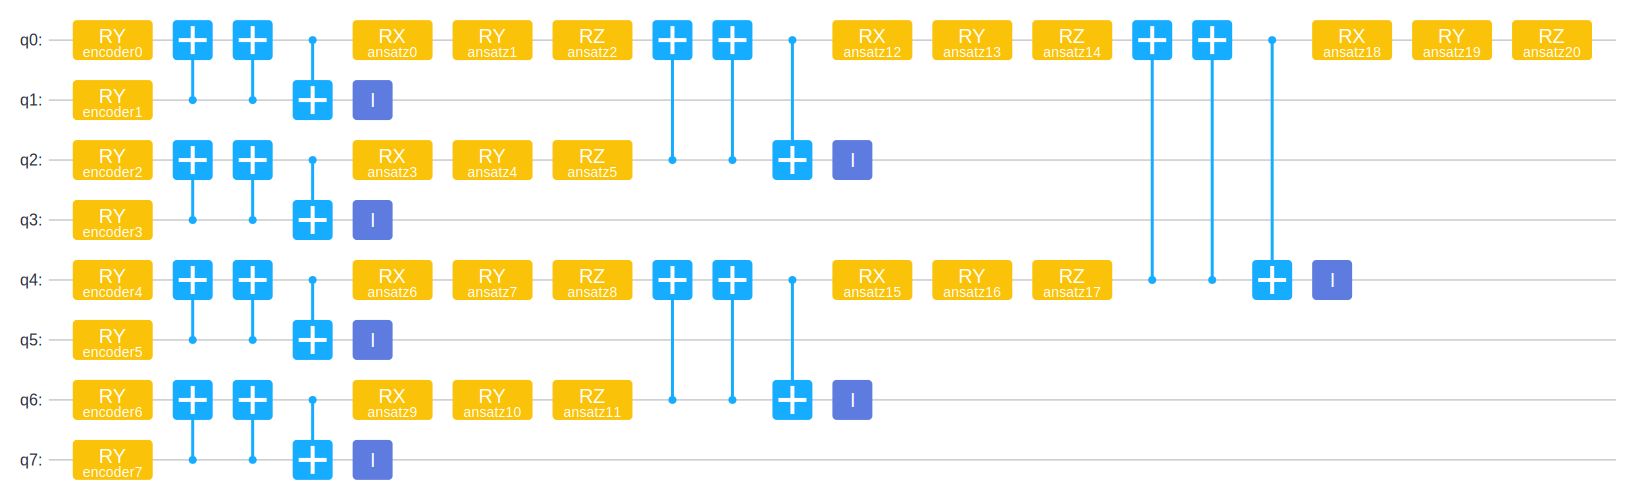

In [7]:
stp_for_test = ops_onehot(
    ms.Tensor(best_candidates_history[-1]), shape_parametized + shape_unparameterized, ms.Tensor(1), ms.Tensor(0)
)
ansatz = mindspore_ansatz_micro_minipool(
    structure_p=stp_for_test,
    parameterized_pool=parameterized_circuit,
    unparameterized_pool=unparameterized_circuit,
    num_layer=num_layer,
    n_qbits=8,
)
ansatz.svg()

In [8]:
from dqas_tool import nnp_dealwith

nnp = ansatz_params_history[-1]
nnp_finnal = nnp_dealwith(structure_params=stp_for_test, network_params=nnp, shape_parameterized=shape_parametized)
np.save('最终ansatz变分参数.npy', nnp)

### 可视化训练过程

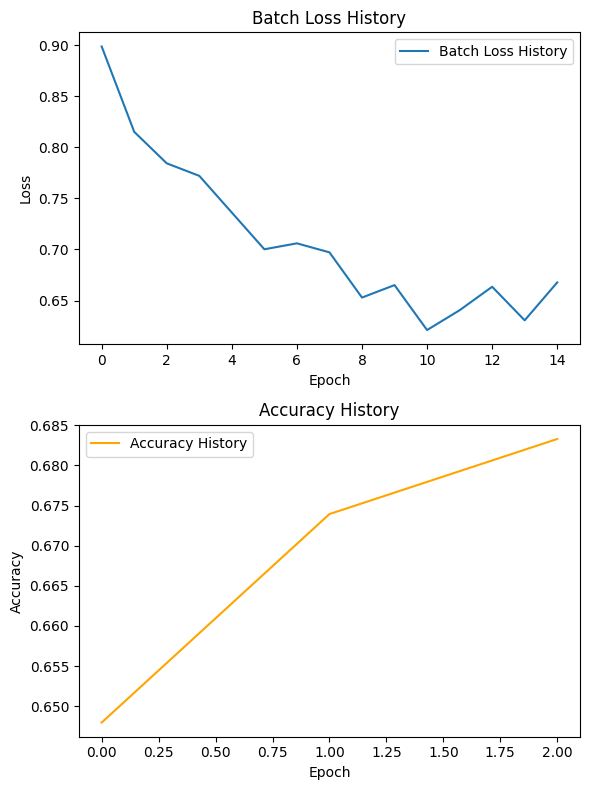

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
# 绘制第一个子图
ax1.plot(range(len(batch_loss_history)), batch_loss_history, label='Batch Loss History')
ax1.set_title('Batch Loss History')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
# ax1.grid(True)

# 绘制第二个子图
ax2.plot(range(len(acc_history)), acc_history, label='Accuracy History', color='orange')
ax2.set_title('Accuracy History')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
# ax2.grid(True)

# 调整布局
plt.tight_layout()
# 显示图形
plt.show()

In [ ]:
from data_preprocessing import x_fulldata, y_fulldata
#type(y_fulldata) # <class 'numpy.ndarray'>
acc = dqas_accuracy_custom(ansatz=ansatz, network_params=nnp_finnal, x=x_fulldata, y=y_fulldata, n_qbits=8)
print(f'在完整的数据集(11446)上的精度为:{acc*100}%')

在完整的数据集(11446)上的精度为:72.17196447837995%


#### 最终在完整数据集上的精度为 97.4%+ 经过进一步微调可以更高 已经达到验收要求！